# Sentiment Polarity Prediction with Naive Bayes

This notebook contains a basic implementation of document-level sentiment analysis
for movie reviews with multinomial Naive Bayes and bag-of-words features
and of cross-validation.
* No special treatment of rare or unknown words. Unknown words in the test data are skipped.

We use the movie review polarity data set of Pang and Lee 2004 [A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts](https://www.aclweb.org/anthology/P04-1035/) in Version 2.0 available from http://www.cs.cornell.edu/People/pabo/movie-review-data (section "Sentiment polarity datasets"). This dataset contains 1000 positive and 1000 negative reviews, each tokenised, sentence-split (one sentence per line) and lowercased. Each review has been assigned to 1 of 10 cross-validation folds by the authors and this setup should be followed to compare with published results.


In [1]:
import os
import tarfile
import time
import urllib.request
import numpy
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import nltk
import matplotlib.pyplot as plt
from IPython.display import clear_output

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

data_source = 'local-folder'
data_folder = os.path.join('data', 'txt_sentoken')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ivan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ivan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
class PL04DataLoader_Part_1:
    
    def __init__(self):
        pass
    
    def get_labelled_dataset(self, fold = 0):
        ''' Compile a fold of the data set
        '''
        dataset = []
        for label in ('pos', 'neg'):
            for document in self.get_documents(
                fold = fold,
                label = label,
            ):
                dataset.append((document, label))
        return dataset
    
    def get_documents(self, fold = 0, label = 'pos'):
        ''' Enumerate the raw contents of all data set files.
            Args:
                data_dir: relative or absolute path to the data set folder
                fold: which fold to load (0 to n_folds-1)
                label: 'pos' or 'neg' to
                    select data with positive or negative sentiment
                    polarity
            Return:
                List of tokenised documents, each a list of sentences
                that in turn are lists of tokens
        '''
        raise NotImplementedError

In [3]:
class PL04DataLoader(PL04DataLoader_Part_1):
    
    def get_xval_splits(self):
        ''' Split data with labels for cross-validation
            returns a list of k pairs (training_data, test_data)
            for k cross-validation
        '''
        # load the folds
        folds = []
        for i in range(10):
            folds.append(self.get_labelled_dataset(
                fold = i
            ))
        # create training-test splits
        retval = []
        for i in range(10):
            test_data = folds[i]
            training_data = []
            for j in range(9):
                ij1 = (i+j+1) % 10
                assert ij1 != i
                training_data = training_data + folds[ij1]
            retval.append((training_data, test_data))
        return retval

In [4]:
class PL04DataLoaderFromStream(PL04DataLoader):
        
    def __init__(self, tgz_stream, **kwargs):
        super().__init__(**kwargs)
        self.data = {}
        counter = 0
        with tarfile.open(
            mode = 'r|gz',
            fileobj = tgz_stream
        ) as tar_archive:
            for tar_member in tar_archive:
                if counter == 2000:
                    break
                path_components = tar_member.name.split('/')
                filename = path_components[-1]
                if filename.startswith('cv') \
                and filename.endswith('.txt') \
                and '_' in filename:
                    label = path_components[-2]
                    fold = int(filename[2])
                    key = (fold, label)
                    if key not in self.data:
                        self.data[key] = []
                    f = tar_archive.extractfile(tar_member)
                    document = [
                        line.decode('utf-8').split()
                        for line in f.readlines()
                    ]
                    self.data[key].append(document)
                    counter += 1
            
    def get_documents(self, fold = 0, label = 'pos'):
        return self.data[(fold, label)]

## Read Data from the Web
This should run efficiently both on google colab and locally but has the disadvantage that the same data is downloaded each time the notebook is run.

In [5]:
class PL04DataLoaderFromURL(PL04DataLoaderFromStream):
    
    def __init__(self, data_url, **kwargs):
        with urllib.request.urlopen(data_url) as tgz_stream:
            super().__init__(tgz_stream, **kwargs)

## Read Data from a Local .tgz File

You manually download the .tgz once to a filesystem that can be accessed from the notebook, e.g. google drive on colab, and this notebook reads this file in one chunk. 

Note that if you are accessing files from google drive on colab, you will need to mount your drive and enter an authentication token:

```
from google.colab import drive
drive.mount('/content/drive')
```

You will also have to change your *data_tgz* or *data_folder* paths above so that they start with *'/content/drive/My Drive/'*

In [6]:
class PL04DataLoaderFromTGZ(PL04DataLoaderFromStream):
    
    def __init__(self, data_path, **kwargs):
        with open(data_path, 'rb') as tgz_stream:
            super().__init__(tgz_stream, **kwargs)

## Read Data from a Local Folder

Extract the .tgz to a local folder and only load the required files. This is usually the fastest option when storage is on a local SSD. On remote filesystems, however, this can be very slow.

In [7]:
class PL04DataLoaderFromFolder(PL04DataLoader):
    
    def __init__(self, data_dir, **kwargs):
        self.data_dir = data_dir
        super().__init__(**kwargs)
        
    def get_documents(self, fold = 0, label = 'pos'):
        # read folder contents
        path = os.path.join(self.data_dir, label)
        dir_entries = os.listdir(path)
        # must process entries in numeric order to
        # replicate order of original experiments
        dir_entries.sort()
        # check each entry and add to data if matching
        # selection criteria
        for filename in dir_entries:
            if filename.startswith('cv') \
            and filename.endswith('.txt'):
                if fold == int(filename[2]):
                    # correct fold
                    f = open(os.path.join(path, filename), 'rt')
                    # "yield" tells Python to return an iterator
                    # object that produces the yields of this
                    # function as elements without creating a
                    # full list of all elements
                    yield [line.split() for line in f.readlines()]
                    f.close()

In [8]:
if data_source == 'local-folder':
    data_loader = PL04DataLoaderFromFolder(data_folder)
elif data_source == 'local-tgz':
    data_loader = PL04DataLoaderFromTGZ(data_tgz)
elif data_source == 'web':
    data_loader = PL04DataLoaderFromURL(data_url)
else:
    raise ValueError('Unsupported data source %r' %data_source)

In [9]:
def get_document_preview(document, max_length = 72):
    s = []
    count = 0
    reached_limit = False
    for sentence in document:
        for token in sentence:
            if count + len(token) + len(s) > max_length:
                reached_limit = True
                break
            s.append(token)
            count += len(token)
        if reached_limit:
            break
    return '|'.join(s)
    
for label in 'pos neg'.split():
    print(f'== {label} ==')
    print('doc sentences start of first sentence')
    for index, document in enumerate(data_loader.get_documents(
        label = label
    )):
        print('%3d %7d   %s' %(
            index, len(document), get_document_preview(document)
        ))
        if index == 4:
            break

== pos ==
doc sentences start of first sentence
  0      25   films|adapted|from|comic|books|have|had|plenty|of|success|,|whether
  1      39   every|now|and|then|a|movie|comes|along|from|a|suspect|studio|,|with
  2      19   you've|got|mail|works|alot|better|than|it|deserves|to|.|in|order|to|make
  3      42   "|jaws|"|is|a|rare|film|that|grabs|your|attention|before|it|shows|you|a
  4      25   moviemaking|is|a|lot|like|being|the|general|manager|of|an|nfl|team|in
== neg ==
doc sentences start of first sentence
  0      35   plot|:|two|teen|couples|go|to|a|church|party|,|drink|and|then|drive|.
  1      13   the|happy|bastard's|quick|movie|review|damn|that|y2k|bug|.|it's|got|a
  2      23   it|is|movies|like|these|that|make|a|jaded|movie|viewer|thankful|for|the
  3      19   "|quest|for|camelot|"|is|warner|bros|.|'|first|feature-length|,
  4      37   synopsis|:|a|mentally|unstable|man|undergoing|psychotherapy|saves|a|boy


## Create Training-Test Splits for Cross-Validation

In [10]:
splits = data_loader.get_xval_splits()

print('tr-size te-size (number of documents)')
for xval_tr_data, xval_te_data in splits:
    print('%7d %7d' %(len(xval_tr_data), len(xval_te_data)))

tr-size te-size (number of documents)
   1800     200
   1800     200
   1800     200
   1800     200
   1800     200
   1800     200
   1800     200
   1800     200
   1800     200
   1800     200


# Interface for Sentiment Polarity Predictor
Let's define a base class to clarify how we plan to use polarity predictors. Its functions will have to be implemented in sub-classes.

In [12]:
class PolarityPredictorInterface:

    def train(self, data_with_labels):
        raise NotImplementedError
        
    def predict(self, data):
        raise NotImplementedError

In [13]:
class PolarityPredictorInit(PolarityPredictorInterface):
    
    def train(self, data_with_labels, feature):
        """
        Function which trains model.
        
        Lemmatisation, negation and removal of stopwords are performed on the data first.
        
        Then the feature matrix is created using extract_features function.
        
        This will be based on bag of unigrams, bigrams or trigrams depending on input.
        
        The targets are then fetched and passed to the learning model for training.
        """

        # Initialise ngram set objects
        self.reset_feature_sets()

        if self.lemmatise:
            """
            Get Penn POS tags
            Convert to WordNet POS tags and retrieve lemma
            Reset data
            """
            tagged_data = self.get_pos_tags(data_with_labels)
            lemmatised_data = self.lemmatise_data(tagged_data)
            data_with_labels = lemmatised_data
        
        if self.negation:
            """
            'NOT_' is added to tokens which are negated.
            """
            self.add_negation_to_data(data_with_labels)
            
        if self.remove_stopwords:
            """
            Stopwords are retrieved from NLTK library and are removed if found in the data.
            """
            self.get_stopwords()
            self.remove_stopwords_from_data(data_with_labels)
            
            
        self.add_to_feature_sets_from_data(data_with_labels)
        self.finalise_feature_sets()
        
        tr_features = self.extract_features(data_with_labels, feature)
        
        if self.additional_features:
            """
            Additional features: (for each document)
            Positive sentiment lexicon counts 
            Negative sentiment lexicon counts
            Negated word counts
            Added as columns to existing feature matrix
            """
            self.get_sentiment_lexicons()
            tr_features = self.add_additional_features(data_with_labels, tr_features, self.negation)
            
        tr_targets = self.get_targets(data_with_labels)
        self.train_model_on_features(tr_features, tr_targets)

    def reset_feature_sets(self):
        self.unigrams = set()
        self.bigrams = set()
        self.trigrams = set()
        self.doc2negate = None
        self.stopwords = None
        self.unigram2index = None
        self.bigram2index = None
        self.trigram2index = None
        self.positive_lexicons = None
        self.negative_lexicons = None
        self.doc2poslex = None
        self.doc2neglex = None
    
    def get_pos_tags(self, data):
        tagged_data = []
        for document, label in data:
            new_document = []
            for sentence in document:
                tagged_sentence = nltk.pos_tag(sentence)
                new_document.append(tagged_sentence)
            new_entry = (new_document, label)
            tagged_data.append(new_entry)
        return tagged_data

    def lemmatise_data(self, data):
        """
        POS has been retieved as in Penn form
        We convert to WordNet form by taking first letter of Penn POS
        """
        lemmatizer = nltk.stem.WordNetLemmatizer()
        for document, label in data:
            for sentence in document:
                for index, token in enumerate(sentence):
                    word = token[0]
                    penn_pos = token[1]
                    if penn_pos[0] == 'N':
                        wn_pos = nltk.corpus.wordnet.NOUN
                    elif penn_pos[0] == 'J':
                        wn_pos = nltk.corpus.wordnet.ADJ
                    elif penn_pos[0] == 'V':
                        wn_pos = nltk.corpus.wordnet.VERB
                    elif penn_pos[0] == 'R':
                        wn_pos = nltk.corpus.wordnet.ADV
                    else:
                        sentence[index] = lemmatizer.lemmatize(word)
                        continue
                    sentence[index] = lemmatizer.lemmatize(word, wn_pos)
        return data
    
    def add_negation_to_data(self, data):
        """
        if 'no' or 'not' or "...n't" are found, 
        words are negated until end of sentence.
        """
        self.doc2negate = []
        for document, label in data:
            negate_total = 0
            for sentence in document:
                negate = False
                for index, token in enumerate(sentence):
                    if token in ('not', 'no') or (token[-3:] == "n't"):
                        negate = True
                        continue
                    if token == '.':
                        negate = False
                    if negate:
                        sentence[index] = 'NOT_' + token
                        negate_total += 1
            self.doc2negate.append(negate_total)
    
    def remove_stopwords_from_data(self, data):
        for document, label in data:
            for sentence in document:
                stopword_indices = []
                for index, token in enumerate(sentence):
                    if token in self.stopwords:
                        stopword_indices.append(index)
                stopword_indices.reverse()
                # we delete stopwords in place, by deleting the latest index first.
                for index in stopword_indices:
                    del sentence[index]
    
    def get_stopwords(self):
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
    
    def get_sentiment_lexicons(self):
        """
        We form lists of positive and negative sentiment lexicons.
        We used data from MPQA: http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/
        """
        sentiment_lexicon_data = "data/sentiment_lexicons.tff"
    
        self.positive_lexicons = []
        self.negative_lexicons = []
        with open(sentiment_lexicon_data, 'r') as f:
            while len(f.readline()) != 0:
                toks = f.readline().split()
                word = toks[2].split("=")[1]
                polarity = toks[-1].split("=")[1]
                if polarity in ("positive", "negative"):
                    if polarity == 'positive':
                        self.positive_lexicons.append(word)
                    if polarity == 'negative':
                        self.negative_lexicons.append(word)
        
    def add_to_feature_sets_from_data(self, data):
        """
        Parses tokens in data and adds them to each feature set.
        """
        for document, label in data:
            for sentence in document:
                sentence.insert(0, '<s>')
                sentence.append('</s>')
                prev_token = None
                for index, token in enumerate(sentence):
                    self.unigrams.add(token)
                    if index > 0:
                        bigram = (prev_token, token)
                        self.bigrams.add(bigram)
                    if index > 1:
                        trigram = (prev_prev_token, prev_token, token)
                        self.trigrams.add(trigram)
                    prev_prev_token = prev_token
                    prev_token = token
                        
    def finalise_feature_sets(self):
        """
        Creates a dict for the feature sets for faster operations.
        """
        self.unigrams = list(self.unigrams)
        # create reverse map for fast token lookup
        self.unigram2index = {}
        for index, token in enumerate(self.unigrams):
            self.unigram2index[token] = index
            
        self.bigrams = list(self.bigrams)
        # create reverse map for fast token lookup
        self.bigram2index = {}
        for index, token in enumerate(self.bigrams):
            self.bigram2index[token] = index
            
        self.trigrams = list(self.trigrams)
        # create reverse map for fast token lookup
        self.trigram2index = {}
        for index, token in enumerate(self.trigrams):
            self.trigram2index[token] = index
        
        
    def extract_features(self, data, feature):
        raise NotImplementedError
    
    def get_targets(self, data, label2index = None):
        raise NotImplementedError
        
    def train_model_on_features(self, tr_features, tr_targets):
        raise NotImplementedError

In [14]:
class PolarityPredictorExtractFeatures(PolarityPredictorInit):
    
    def __init__(self, clip_counts = True, negation=False, remove_stopwords=False, lemmatise=False, additional_features=False, learning_model=MultinomialNB()):
        self.clip_counts = clip_counts
        self.negation = negation
        self.remove_stopwords = remove_stopwords
        self.model = learning_model
        self.lemmatise = lemmatise
        self.additional_features = additional_features
        
    def extract_features(self, data, ngram):
        """
        Creates features from the data.
        Depending on the input, a feature matrix for bag of words, bag of bigrams or bag of trigrams is created.
        """
        rows = len(data)
        feature_matrices = {}
        # Initialise a feature matrix with zeros
        feature_matrices['unigram'] = numpy.zeros((rows, len(self.unigrams)), dtype=numpy.int32)
        feature_matrices['bigram'] = numpy.zeros((rows, len(self.bigrams)), dtype=numpy.int32)
        feature_matrices['trigram'] = numpy.zeros((rows, len(self.trigrams)), dtype=numpy.int32)
        # populate feature matrix
        for row, item in enumerate(data):
            document, _ = item
            for sentence in document:
                if sentence[0] != '<s>':
                    sentence.insert(0, '<s>')
                if sentence[-1] != '</s>':
                    sentence.append('</s>')
                prev_token = None
                for idx, token in enumerate(sentence):
                    if ngram == 'unigram':
                        try:
                            unigram_index = self.unigram2index[token]
                        except KeyError:
                            continue
                        if self.clip_counts:
                            feature_matrices['unigram'][row, unigram_index] = 1
                        else:
                            feature_matrices['unigram'][row, unigram_index] += 1
                    if ngram == 'bigram':
                        if idx > 0:
                            bigram = (prev_token, token)
                            try:
                                bigram_index = self.bigram2index[bigram]
                            except KeyError:
                                continue
                            if self.clip_counts:
                                feature_matrices['bigram'][row, bigram_index] = 1
                            else:
                                feature_matrices['bigram'][row, bigram_index] += 1
                    if ngram == 'trigram':
                        if idx > 1:
                            trigram = (prev_prev_token, prev_token, token)
                            try:
                                trigram_index = self.trigram2index[trigram]
                            except KeyError:
                                continue
                            if self.clip_counts:
                                feature_matrices['trigram'][row, trigram_index] = 1
                            else:
                                feature_matrices['trigram'][row, trigram_index] += 1

                    prev_prev_token = prev_token
                    prev_token = token
        return feature_matrices[ngram]
        
    def add_additional_features(self, data, feature_matrix, negation):
        """
        Additional features representing number of positive lexicons, number of negative lexicons
        and number of negated words are added to the existing feature matrix built above.
        """
        self.doc2poslex = []
        self.doc2neglex = []
        for row, item in enumerate(data):
            document, _ = item
            doc_pos_tot = 0
            doc_neg_tot = 0
            for sentence in document:
                for token in sentence:
                    if token in self.positive_lexicons:
                        doc_pos_tot += 1
                    if token in self.negative_lexicons:
                        doc_neg_tot += 1
            self.doc2poslex.append(doc_pos_tot)
            self.doc2neglex.append(doc_neg_tot)
        if negation:
            additional_features = numpy.array((self.doc2negate, self.doc2poslex, self.doc2neglex)).T
        else:
            additional_features = numpy.array((self.doc2poslex, self.doc2neglex)).T
        new_feature_matrix = numpy.append(feature_matrix, additional_features, 1)
        return new_feature_matrix

In [15]:
class PolarityPredictorAssignTargets(PolarityPredictorExtractFeatures):
 
    def get_targets(self, data):
        ''' 
        Column vector with target labels is created.
        '''
        targets = numpy.zeros(len(data), dtype=numpy.int8)
        index = 0
        for _, label in data:
            if label == 'pos':
                targets[index] = 1
            index += 1
        return targets

    def train_model_on_features(self, tr_features, tr_targets):
        raise NotImplementedError

In [16]:
class PolarityPredictor(PolarityPredictorAssignTargets):

    def train_model_on_features(self, tr_features, tr_targets):
        self.model.fit(tr_features, tr_targets)
        
    def predict(self, data, feature, get_accuracy = False, get_confusion_matrix = False):
        
        if self.lemmatise:
            tagged_data = self.get_pos_tags(data)
            lemmatised_data = self.lemmatise_data(tagged_data)
            data = lemmatised_data
        
        if self.negation:
            self.add_negation_to_data(data)
        
        if self.remove_stopwords:
            self.remove_stopwords_from_data(data)
        
        features = self.extract_features(data, feature)
        
        if self.additional_features:
            self.get_sentiment_lexicons()
            features = self.add_additional_features(data, features, self.negation)
            
        y_pred = self.model.predict(features)
        
        labels = []
        for is_positive in y_pred:
            if is_positive:
                labels.append('pos')
            else:
                labels.append('neg')
                
        if get_accuracy or get_confusion_matrix:
            retval = []
            retval.append(labels)
            y_true = self.get_targets(data)
            if get_accuracy:
                retval.append(metrics.accuracy_score(y_true, y_pred))
            if get_confusion_matrix:
                retval.append(metrics.confusion_matrix(y_true, y_pred))
            return retval
        else:
            return labels

In [17]:
def evaluate_model(model, splits, feature, verbose = False):
    accuracies = []
    fold = 0
    for tr_data, te_data in splits:
        if verbose:
            print('Evaluating fold %d of %d' %(fold+1, len(splits)))
            fold += 1
        model.train(tr_data, feature)
        _, accuracy = model.predict(te_data, feature, get_accuracy = True)
        accuracies.append(accuracy)
        if verbose:
            print('-->', accuracy)
    n = float(len(accuracies))
    avg = sum(accuracies) / n
    mse = sum([(x-avg)**2 for x in accuracies]) / n
    return (avg, mse**0.5, min(accuracies),
            max(accuracies))

def print_first_predictions(model, te_data, feature, n = 12):
    predictions = model.predict(te_data, feature)
    for i in range(n):
        document, label = te_data[i]
        prediction = predictions[i]
        print('%4d %s %s %s' %(i, label, prediction, get_document_preview(document),))

# Baseline Model

We plan to run many different experiments using different feature representations and different learning models.   Therefore, having an evaluation table which contains the details of each experiment and the corresponding evalation results will be useful. 
The following values will be recorded in the dataframe for each model:
* Average 10 Fold Cross-Validation Accuracy
* Root Mean Square Error (RMSE)
* Minimum Accuracy
* Maximum Accuracy

Below, we define table to store these.

We want to beat the baseline model which uses <b>clip counts</b> and <b>MultinomialNB</b>. We will test that model below and store the data as *baseline-NB* in the dataframe.

In [18]:
learning_model = MultinomialNB()

In [19]:
evaluation_dataframes = {}
evaluation_dataframes['MultinomialNB'] = pd.DataFrame(columns=['name', 'learning_model', 'feature', 'clip_counts', 'negation', 'remove_stopwords', 'lemmatise', 'additional_features', 'avg_cv_acc', 'rmse', 'min_acc', 'max_acc'])

We run the baseline approach as a functionality test. The settings used are listed in the cell below.

In [20]:
clip_counts = True
negation = False
remove_stopwords = False
lemmatise = False
additional_features = False
feature = 'unigram'

In [21]:
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
baseline_avg, baseline_rmse, baseline_min_acc, baseline_max_acc = evaluate_model(model, splits, feature, verbose = False)
evaluation_dataframes['MultinomialNB'].loc[0] = ['baseline-NB', learning_model, feature, clip_counts, negation, remove_stopwords, lemmatise, additional_features, baseline_avg, baseline_rmse, baseline_min_acc, baseline_max_acc]

So, the baseline approach achieves an average accuracy score of 82.9% and has been to our evaluation table. The format of this dataframe can be seen below:

In [22]:
evaluation_dataframes['MultinomialNB']

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-NB,MultinomialNB(),unigram,True,False,False,False,False,0.829,0.021071,0.785,0.855


# Experiments

Our model builds three different feature representations from the input data:
* Bag-of-Words (Unigrams)
* Bag-of-Bigrams
* Bag-of-Trigrams

The *PolarityPredictor* model takes in a *feature* parameter which specifies which feature of the above to use. There is also a *learning_model* parameter which specifies which particular learning model to use.

The model can also be tweaked to perform the following:
* Clip Counts in feature matrices
* Negation
* Removal of StopWords
* Lemmatisation
* Include additional features

In the following section of the notebook we will experiment to see how the added features affect accuracy.

## Experiment 1 & 2: Bag of Bigrams and Bag of Trigrams

The first change which we implemented in the code was to add bigram and trigram feature sets. We initialised two extra sets in order to store the bigrams and trigrams in the *reset_feature_sets* function. The bigrams and trigrams were then added to these new sets in the *add_to_feature_sets_from_data* function.

This was done by checking if the index of the token was greater than zero before adding bigrams and checking if it was greater than one before adding trigrams. We also escaped the start and end of sentences using the respective '\<s>' and '\</s>' tags. In the *finalise_feature_sets* function, a reverse map dictionary is created for both bigrams and trigrams, similar to that which was done for unigrams originally. This enables faster lookup when populating the feature matrix.

In order to store a feature matrix for each implementation, we originally created a *feature_matrices* dict in the *extract_features* function. However, when building all three feature matrices, computation time proved to be too long. Therefore, in order to save time in computations, only the feature matrix which is being used (either unigram, bigram or trigram), is populated in the function.

In [23]:
index = 1
for feature in ['bigram', 'trigram']:
    model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
    avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
    evaluation_dataframes['MultinomialNB'].loc[evaluation_dataframes['MultinomialNB'].index.max()+1] = [f'param-exp-NB-{index}', learning_model, feature, clip_counts, 
                                                  negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
    index += 1

Evaluating fold 1 of 10
--> 0.805
Evaluating fold 2 of 10
--> 0.86
Evaluating fold 3 of 10
--> 0.82
Evaluating fold 4 of 10
--> 0.86
Evaluating fold 5 of 10
--> 0.85
Evaluating fold 6 of 10
--> 0.82
Evaluating fold 7 of 10
--> 0.865
Evaluating fold 8 of 10
--> 0.825
Evaluating fold 9 of 10
--> 0.835
Evaluating fold 10 of 10
--> 0.855
Evaluating fold 1 of 10
--> 0.745
Evaluating fold 2 of 10
--> 0.745
Evaluating fold 3 of 10
--> 0.755
Evaluating fold 4 of 10
--> 0.805
Evaluating fold 5 of 10
--> 0.79
Evaluating fold 6 of 10
--> 0.79
Evaluating fold 7 of 10
--> 0.785
Evaluating fold 8 of 10
--> 0.77
Evaluating fold 9 of 10
--> 0.745
Evaluating fold 10 of 10
--> 0.755


<AxesSubplot:title={'center':'Comparison of different ngram feature representation accuracy using baseline settings (RMSE)'}>

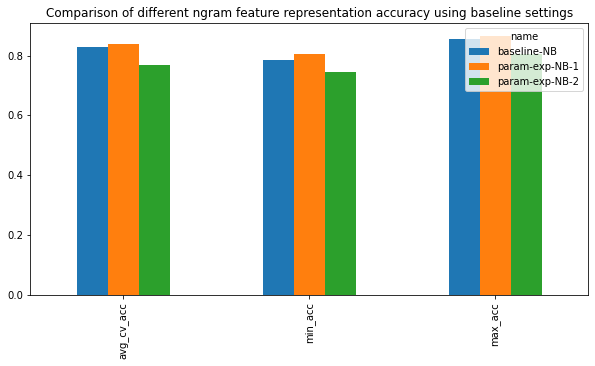

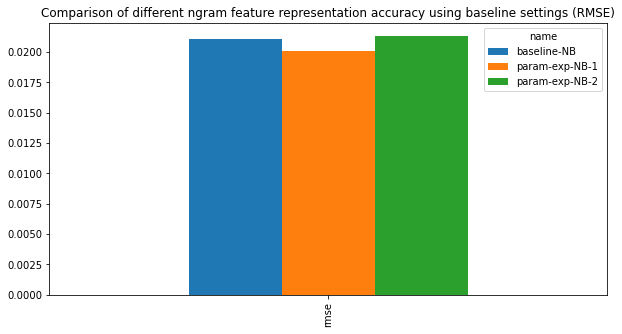

In [24]:
ngram_comparison = evaluation_dataframes['MultinomialNB'][["name", "avg_cv_acc", "min_acc", "max_acc"]]
graph = ngram_comparison.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of different ngram feature representation accuracy using baseline settings")

ngram_comparison_rmse = evaluation_dataframes['MultinomialNB'][["name", "rmse"]]
graph = ngram_comparison_rmse.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of different ngram feature representation accuracy using baseline settings (RMSE)")

In [25]:
evaluation_dataframes['MultinomialNB']

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-NB,MultinomialNB(),unigram,True,False,False,False,False,0.8290,0.021071,0.785,0.855
1,param-exp-NB-1,MultinomialNB(),bigram,True,False,False,False,False,0.8395,0.020056,0.805,0.865
2,param-exp-NB-2,MultinomialNB(),trigram,True,False,False,False,False,0.7685,0.021337,0.745,0.805


### We can see above that the Bag-of-Bigrams is the best feature representation to use as input for the baseline model.  
### However, in order to effectively test the rest of our features, we will continue using the unigram feature representation.

## Experiment 3: Clip Counts

The baseline model has a clip counts feature which limits the numbers in the feature matrix to either 0 or 1. Below we test the effect of disabling this feature and allowing the count of the terms in the matrix be greater than 1.

In [26]:
feature = 'unigram'
clip_counts = False
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['MultinomialNB'].loc[evaluation_dataframes['MultinomialNB'].index.max()+1] = [f'param-exp-NB-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.75
Evaluating fold 2 of 10
--> 0.84
Evaluating fold 3 of 10
--> 0.83
Evaluating fold 4 of 10
--> 0.805
Evaluating fold 5 of 10
--> 0.82
Evaluating fold 6 of 10
--> 0.8
Evaluating fold 7 of 10
--> 0.8
Evaluating fold 8 of 10
--> 0.82
Evaluating fold 9 of 10
--> 0.77
Evaluating fold 10 of 10
--> 0.815


<AxesSubplot:title={'center':'Comparison of baseline model with and without clipped counts (RMSE)'}>

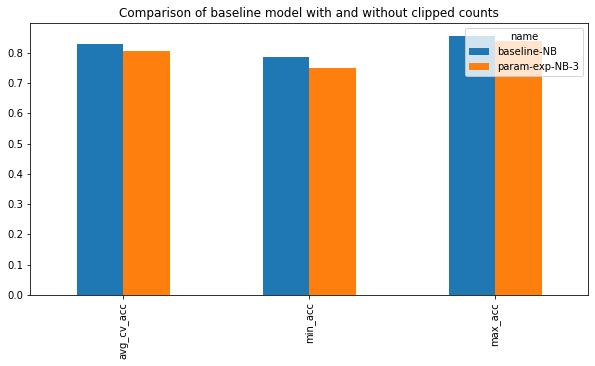

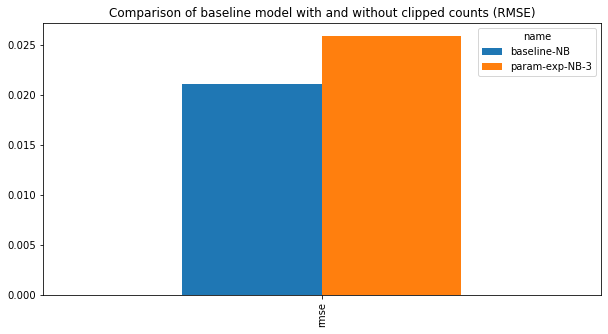

In [29]:
clip_counts_comparison = evaluation_dataframes['MultinomialNB'].iloc[[0, 3],]
clip_counts_comparison = clip_counts_comparison[["name", "avg_cv_acc", "min_acc", "max_acc"]]
graph = clip_counts_comparison.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without clipped counts")
clip_counts_comparison_rmse = evaluation_dataframes['MultinomialNB'].iloc[[0, 3],]
clip_counts_comparison_rmse = clip_counts_comparison_rmse[["name", "rmse"]]
graph = clip_counts_comparison_rmse.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without clipped counts (RMSE)")

In [30]:
evaluation_dataframes['MultinomialNB']

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-NB,MultinomialNB(),unigram,True,False,False,False,False,0.8290,0.021071,0.785,0.855
1,param-exp-NB-1,MultinomialNB(),bigram,True,False,False,False,False,0.8395,0.020056,0.805,0.865
2,param-exp-NB-2,MultinomialNB(),trigram,True,False,False,False,False,0.7685,0.021337,0.745,0.805
3,param-exp-NB-3,MultinomialNB(),unigram,False,False,False,False,False,0.8050,0.025884,0.750,0.840


### Clipped counts work marginally better with the unigram feature representation. This makes sense as the learning model can identify differences within the data easier given the data is binary.

## Experiment 4: Remove Stopwords

We also created a parameter in our model for removing stop words. The list of stop words which we used is from the English stop word list accessed through NLTK. These are shown below.

Stop words are removed from the data in the *remove_stopwords_from_data* function. This function works by storing the indices of stop words when iterating through each sentence and then removing these from the list of sentence tokens.

In [31]:
print(set(nltk.corpus.stopwords.words('english')))

{'what', 'by', 'off', "mustn't", 'they', 'with', "couldn't", 'it', 'so', "should've", 'that', "you'd", 'below', "shouldn't", 'between', 'out', 'mightn', 'do', "you've", 've', 'how', 'few', 'did', 'hers', "haven't", 'doesn', 'then', 't', "wouldn't", "you'll", "won't", 'yours', 'should', 'he', 'my', 'of', 'you', 'shouldn', "needn't", 'isn', "you're", 'been', 'doing', 'those', 'has', 'yourselves', 'the', 'against', 'me', 'ours', "hadn't", 'about', 'll', 'from', 'an', 're', 'both', 'ain', 'will', 'their', 'weren', 'your', "doesn't", 'wouldn', 'd', 'were', 'over', "that'll", 'does', 'into', "didn't", "she's", 'is', 'aren', "wasn't", 'under', 'only', 'and', 'in', 'for', 'her', 'each', "it's", 'because', 'why', 'had', 'most', 'don', "hasn't", "mightn't", 'needn', 'herself', 'to', 'have', 'once', 'who', 'here', 'him', 'yourself', 'before', "don't", 'a', 'but', "aren't", 'itself', 'some', 'same', 'couldn', 'while', 'be', 'own', 'nor', 'than', 'mustn', "shan't", 'through', 'all', 'haven', 'up', 

We will inspect the effect of removing these stopwords from the data

In [32]:
clip_counts = True
remove_stopwords = True
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['MultinomialNB'].loc[evaluation_dataframes['MultinomialNB'].index.max()+1] = [f'param-exp-NB-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.815
Evaluating fold 2 of 10
--> 0.84
Evaluating fold 3 of 10
--> 0.85
Evaluating fold 4 of 10
--> 0.81
Evaluating fold 5 of 10
--> 0.84
Evaluating fold 6 of 10
--> 0.835
Evaluating fold 7 of 10
--> 0.865
Evaluating fold 8 of 10
--> 0.85
Evaluating fold 9 of 10
--> 0.775
Evaluating fold 10 of 10
--> 0.86


<AxesSubplot:title={'center':'Comparison of baseline model with and without stop words removed (RMSE)'}>

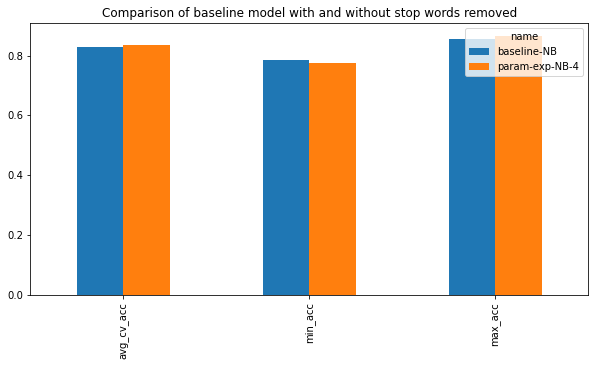

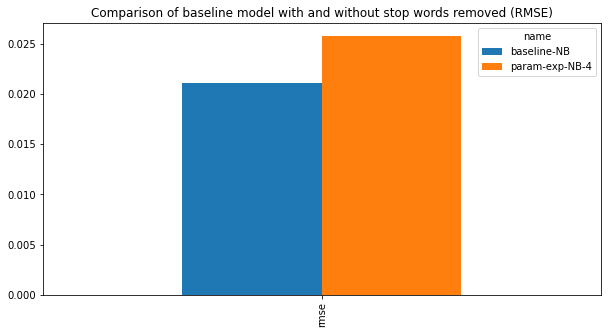

In [33]:
stop_words_comparison = evaluation_dataframes['MultinomialNB'].iloc[[0, 4],]
stop_words_comparison = stop_words_comparison[["name", "avg_cv_acc", "min_acc", "max_acc"]]
graph = stop_words_comparison.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without stop words removed")
clip_counts_comparison_rmse = evaluation_dataframes['MultinomialNB'].iloc[[0, 4],]
clip_counts_comparison_rmse = clip_counts_comparison_rmse[["name", "rmse"]]
graph = clip_counts_comparison_rmse.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without stop words removed (RMSE)")

In [34]:
evaluation_dataframes['MultinomialNB']

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-NB,MultinomialNB(),unigram,True,False,False,False,False,0.8290,0.021071,0.785,0.855
1,param-exp-NB-1,MultinomialNB(),bigram,True,False,False,False,False,0.8395,0.020056,0.805,0.865
2,param-exp-NB-2,MultinomialNB(),trigram,True,False,False,False,False,0.7685,0.021337,0.745,0.805
3,param-exp-NB-3,MultinomialNB(),unigram,False,False,False,False,False,0.8050,0.025884,0.750,0.840
4,param-exp-NB-4,MultinomialNB(),unigram,True,False,True,False,False,0.8340,0.025768,0.775,0.865


### We can see a higher maximum accuracy when stopwords are removed, however we also see a lower minimum accuracy. The increase in range suggests that there may be some words within the stopword corpus which hold meaning. Overall we have achieved the second highest average accuracy so far.

## Experiment 5: Addition of negation to data

Another option which can be toggled when running the model is whether to negate the data or not. Negation is performed in the *add_negation_to_data* function. This function essentially checks if a token is "not", "no" or ends in "n't". When one of these tokens is found, each token following this has "NOT_" prefixed to it until the next full stop in the data. This is a simple but effective way to perform negation.

In the aforementioned function, a vector is also created, called *doc2negate*, which stores the number of negated words in each document. This will be used later on to create additional features. 

In [37]:
remove_stopwords = False
negation = True
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['MultinomialNB'].loc[evaluation_dataframes['MultinomialNB'].index.max()+1] = [f'param-exp-NB-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.815
Evaluating fold 2 of 10
--> 0.84
Evaluating fold 3 of 10
--> 0.855
Evaluating fold 4 of 10
--> 0.805
Evaluating fold 5 of 10
--> 0.83
Evaluating fold 6 of 10
--> 0.83
Evaluating fold 7 of 10
--> 0.85
Evaluating fold 8 of 10
--> 0.845
Evaluating fold 9 of 10
--> 0.79
Evaluating fold 10 of 10
--> 0.855


<AxesSubplot:title={'center':'Comparison of baseline model with and without negation (RMSE)'}>

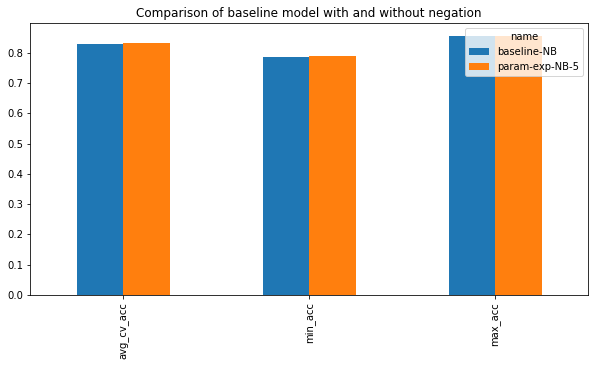

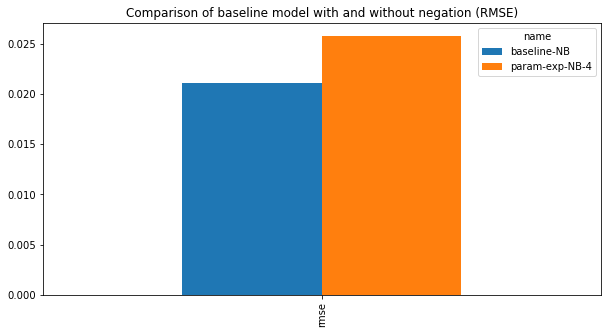

In [38]:
negation_comparison = evaluation_dataframes['MultinomialNB'].iloc[[0, 5],]
negation_comparison = negation_comparison[["name", "avg_cv_acc", "min_acc", "max_acc"]]
graph = negation_comparison.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without negation")
negation_comparison_rmse = evaluation_dataframes['MultinomialNB'].iloc[[0, 5],]
negation_comparison_rmse = negation_comparison_rmse[["name", "rmse"]]
graph = clip_counts_comparison_rmse.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without negation (RMSE)")

In [39]:
evaluation_dataframes['MultinomialNB']

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-NB,MultinomialNB(),unigram,True,False,False,False,False,0.8290,0.021071,0.785,0.855
1,param-exp-NB-1,MultinomialNB(),bigram,True,False,False,False,False,0.8395,0.020056,0.805,0.865
2,param-exp-NB-2,MultinomialNB(),trigram,True,False,False,False,False,0.7685,0.021337,0.745,0.805
3,param-exp-NB-3,MultinomialNB(),unigram,False,False,False,False,False,0.8050,0.025884,0.750,0.840
4,param-exp-NB-4,MultinomialNB(),unigram,True,False,True,False,False,0.8340,0.025768,0.775,0.865
5,param-exp-NB-5,MultinomialNB(),unigram,True,True,False,False,False,0.8325,0.021243,0.790,0.855
6,param-exp-NB-6,MultinomialNB(),unigram,True,True,False,False,False,0.8315,0.020982,0.790,0.855


### We only see a marginal difference when negation is added to the data.

## Experiment 6: Lemmatisation of data

We also included a lemmatisation step which can be toggled when running the model. This step essentially converts each word in the vocabulary to its base form. The lemmatiser which we opted to use is [Wordnet](https://wordnet.princeton.edu/), which is a large, freely available lexical database for the English language. This lemmatiser was downloaded and accessed through the NLTK toolkit. It is implemented in the *lemmatise_data* function.

As a second argument to the lemmatiser, we also pass the Wordnet POS tag for the word. We find the [Penn POS tag](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for each word using *nltk.pos_tag(word)* in the *get_pos_tags* function. This tagged data is then passed to the *lemmatise_data* function where the tags are then mapped to the much simpler Wornet POS tags before being passed into the lemmatiser with each word.

In [42]:
negation = False
lemmatise = True
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['MultinomialNB'].loc[evaluation_dataframes['MultinomialNB'].index.max()+1] = [f'param-exp-NB-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.83
Evaluating fold 2 of 10
--> 0.835
Evaluating fold 3 of 10
--> 0.825
Evaluating fold 4 of 10
--> 0.795
Evaluating fold 5 of 10
--> 0.805
Evaluating fold 6 of 10
--> 0.82
Evaluating fold 7 of 10
--> 0.84
Evaluating fold 8 of 10
--> 0.825
Evaluating fold 9 of 10
--> 0.78
Evaluating fold 10 of 10
--> 0.835


<AxesSubplot:title={'center':'Comparison of baseline model with and without lemmatisation (RMSE)'}>

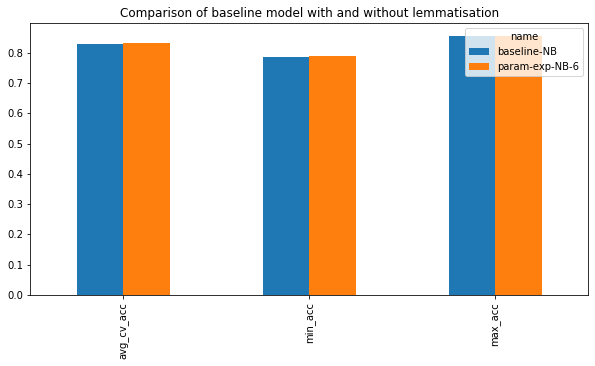

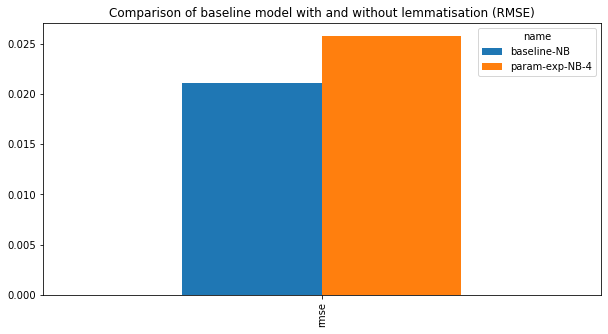

In [43]:
lemmatisation_comparison = evaluation_dataframes['MultinomialNB'].iloc[[0, 6],]
lemmatisation_comparison = lemmatisation_comparison[["name", "avg_cv_acc", "min_acc", "max_acc"]]
graph = lemmatisation_comparison.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without lemmatisation")
lemmatisation_comparison_rmse = evaluation_dataframes['MultinomialNB'].iloc[[0, 6],]
lemmatisation_comparison_rmse = lemmatisation_comparison_rmse[["name", "rmse"]]
graph = clip_counts_comparison_rmse.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without lemmatisation (RMSE)")

In [44]:
evaluation_dataframes['MultinomialNB']

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-NB,MultinomialNB(),unigram,True,False,False,False,False,0.8290,0.021071,0.785,0.855
1,param-exp-NB-1,MultinomialNB(),bigram,True,False,False,False,False,0.8395,0.020056,0.805,0.865
2,param-exp-NB-2,MultinomialNB(),trigram,True,False,False,False,False,0.7685,0.021337,0.745,0.805
3,param-exp-NB-3,MultinomialNB(),unigram,False,False,False,False,False,0.8050,0.025884,0.750,0.840
4,param-exp-NB-4,MultinomialNB(),unigram,True,False,True,False,False,0.8340,0.025768,0.775,0.865
5,param-exp-NB-5,MultinomialNB(),unigram,True,True,False,False,False,0.8325,0.021243,0.790,0.855
6,param-exp-NB-6,MultinomialNB(),unigram,True,True,False,False,False,0.8315,0.020982,0.790,0.855
7,param-exp-NB-7,MultinomialNB(),unigram,True,False,False,True,False,0.8190,0.018547,0.780,0.840


### Use of lemmatisation has also surprisingly resulted in a decrease in accuracy by about 2%. It is possible that lemmatisation and negation could work well together. This is something which is tested as part of our additional experiments.

## Experiment 7: Use of additional features

The final thing which we implemented was the creation of 3 new additional features. The first of these is formed from the *doc2negate* vector mentioned above. This vector shows the number of negated terms in each document. The second and third of these additional features represent positive and negative lexicons respectively. Similar to the *doc2negate* vector, they show the number of terms in each document which are found in positive and negative sentiment lexicons.  
  
The sentiment lexicon which we used was the [MPQA Subjectivity Lexicon](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/). It contains 1340 positive and 2441 negative terms.  
  
These 3 vectors are appended to the feature matrix which was created in the *extract_features* function.

In [45]:
lemmatise = False
additional_features = True
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['MultinomialNB'].loc[evaluation_dataframes['MultinomialNB'].index.max()+1] = [f'param-exp-NB-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.825
Evaluating fold 2 of 10
--> 0.825
Evaluating fold 3 of 10
--> 0.855
Evaluating fold 4 of 10
--> 0.805
Evaluating fold 5 of 10
--> 0.835
Evaluating fold 6 of 10
--> 0.82
Evaluating fold 7 of 10
--> 0.845
Evaluating fold 8 of 10
--> 0.835
Evaluating fold 9 of 10
--> 0.805
Evaluating fold 10 of 10
--> 0.865


<AxesSubplot:title={'center':'Comparison of baseline model with and without additional features (RMSE)'}>

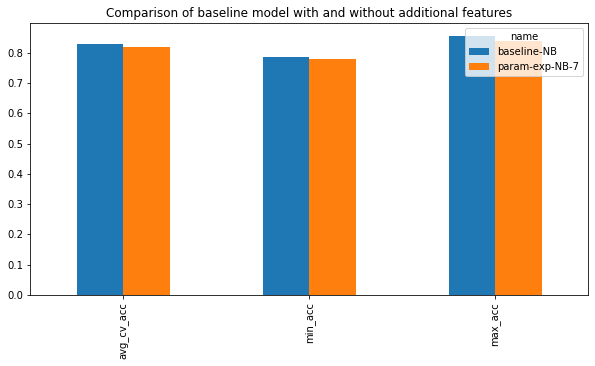

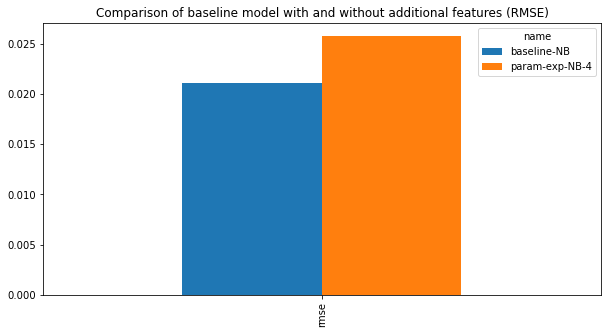

In [46]:
lemmatisation_comparison = evaluation_dataframes['MultinomialNB'].iloc[[0, 7],]
lemmatisation_comparison = lemmatisation_comparison[["name", "avg_cv_acc", "min_acc", "max_acc"]]
graph = lemmatisation_comparison.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without additional features")
lemmatisation_comparison_rmse = evaluation_dataframes['MultinomialNB'].iloc[[0, 7],]
lemmatisation_comparison_rmse = lemmatisation_comparison_rmse[["name", "rmse"]]
graph = clip_counts_comparison_rmse.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of baseline model with and without additional features (RMSE)")

### The use of additional features also lowers accuracy. Perhaps adding them to the feature matrix in another would have worked better.

# Baseline comparison of different learning models

In [61]:
clip_counts = True
negation = False
remove_stopwords = False
lemmatise = False
additional_features = False
feature = 'unigram'
from sklearn.linear_model import LogisticRegression
learning_model = LogisticRegression()
evaluation_dataframes['LearningModels'] = pd.DataFrame(columns=['name', 'learning_model', 'feature', 'clip_counts', 'negation', 'remove_stopwords', 'lemmatise', 'additional_features', 'avg_cv_acc', 'rmse', 'min_acc', 'max_acc'])
row_to_add = evaluation_dataframes['MultinomialNB'].iloc[[0],]
evaluation_dataframes['LearningModels'] = evaluation_dataframes['LearningModels'].append(row_to_add)

In [65]:
index = 1
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['LearningModels'].loc[evaluation_dataframes['LearningModels'].index.max()+1] = [f'lm-exp-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.855
Evaluating fold 2 of 10
--> 0.865
Evaluating fold 3 of 10
--> 0.88
Evaluating fold 4 of 10
--> 0.835
Evaluating fold 5 of 10
--> 0.87
Evaluating fold 6 of 10
--> 0.905
Evaluating fold 7 of 10
--> 0.885
Evaluating fold 8 of 10
--> 0.895
Evaluating fold 9 of 10
--> 0.845
Evaluating fold 10 of 10
--> 0.915


In [66]:
from sklearn.tree import DecisionTreeClassifier
learning_model = DecisionTreeClassifier()
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['LearningModels'].loc[evaluation_dataframes['LearningModels'].index.max()+1] = [f'lm-exp-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.645
Evaluating fold 2 of 10
--> 0.615
Evaluating fold 3 of 10
--> 0.61
Evaluating fold 4 of 10
--> 0.665
Evaluating fold 5 of 10
--> 0.61
Evaluating fold 6 of 10
--> 0.595
Evaluating fold 7 of 10
--> 0.61
Evaluating fold 8 of 10
--> 0.635
Evaluating fold 9 of 10
--> 0.57
Evaluating fold 10 of 10
--> 0.65


In [67]:
from sklearn.svm import SVC
learning_model = SVC()
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['LearningModels'].loc[evaluation_dataframes['LearningModels'].index.max()+1] = [f'lm-exp-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.86
Evaluating fold 2 of 10
--> 0.865
Evaluating fold 3 of 10
--> 0.85
Evaluating fold 4 of 10
--> 0.815
Evaluating fold 5 of 10
--> 0.845
Evaluating fold 6 of 10
--> 0.835
Evaluating fold 7 of 10
--> 0.9
Evaluating fold 8 of 10
--> 0.885
Evaluating fold 9 of 10
--> 0.85
Evaluating fold 10 of 10
--> 0.88


In [68]:
from sklearn.ensemble import RandomForestClassifier
learning_model = RandomForestClassifier()
model = PolarityPredictor(clip_counts, negation, remove_stopwords, lemmatise, additional_features, learning_model)
avg, rmse, min_acc, max_acc = evaluate_model(model, splits, feature, verbose = True)
evaluation_dataframes['LearningModels'].loc[evaluation_dataframes['LearningModels'].index.max()+1] = [f'lm-exp-{index}', learning_model, feature, clip_counts, 
                                              negation, remove_stopwords, lemmatise, additional_features, avg, rmse, min_acc, max_acc]
index += 1

Evaluating fold 1 of 10
--> 0.85
Evaluating fold 2 of 10
--> 0.83
Evaluating fold 3 of 10
--> 0.85
Evaluating fold 4 of 10
--> 0.805
Evaluating fold 5 of 10
--> 0.79
Evaluating fold 6 of 10
--> 0.805
Evaluating fold 7 of 10
--> 0.835
Evaluating fold 8 of 10
--> 0.825
Evaluating fold 9 of 10
--> 0.785
Evaluating fold 10 of 10
--> 0.83


<AxesSubplot:title={'center':'Comparison different learning model accuracy (RMSE)'}>

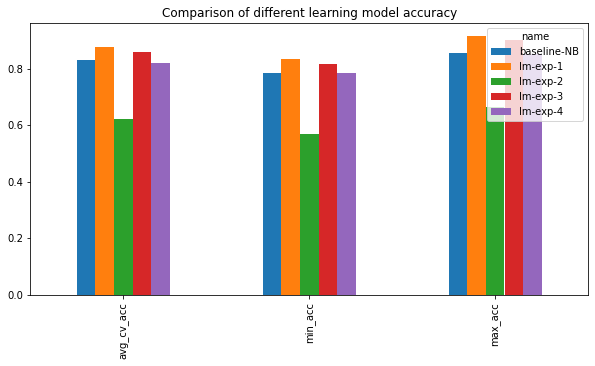

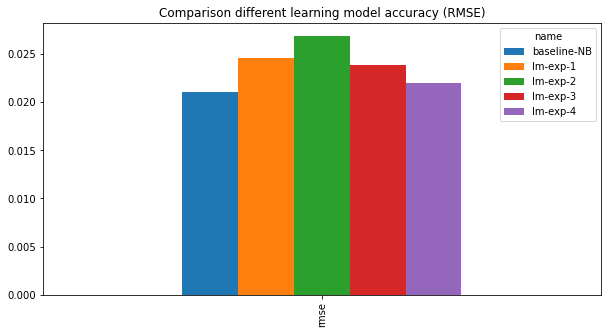

In [69]:
learning_model_comparison = evaluation_dataframes['LearningModels']
learning_model_comparison = learning_model_comparison[["name", "avg_cv_acc", "min_acc", "max_acc"]]
graph = learning_model_comparison.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison of different learning model accuracy")
learning_model_comparison_rmse = evaluation_dataframes['LearningModels']
learning_model_comparison_rmse = learning_model_comparison_rmse[["name", "rmse"]]
graph = learning_model_comparison_rmse.T
graph_header = graph.iloc[0]
graph = graph[1:]
graph.columns = graph_header
graph.plot(kind='bar', figsize=(10,5), title="Comparison different learning model accuracy (RMSE)")

In [70]:
evaluation_dataframes['LearningModels']

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-NB,MultinomialNB(),unigram,True,False,False,False,False,0.8290,0.021071,0.785,0.855
1,lm-exp-1,LogisticRegression(),unigram,True,False,False,False,False,0.8750,0.024597,0.835,0.915
2,lm-exp-2,DecisionTreeClassifier(),unigram,True,False,False,False,False,0.6205,0.026875,0.570,0.665
3,lm-exp-3,SVC(),unigram,True,False,False,False,False,0.8585,0.023880,0.815,0.900
4,lm-exp-4,"(DecisionTreeClassifier(max_features='auto', r...",unigram,True,False,False,False,False,0.8205,0.021960,0.785,0.850


### From the above visualisations and table, we can see that *lm-exp-1* or the LogisticRegression model achieved the highest maximum accuracy of 91.5%. This model also achieved the highest maximum average cross validation accuracy. However, the baseline Muiltinomial Naive Bayes model achieved the lowest RMSE. Another impressive result is that of the SVM Classifier, which achieved the second highest maximum accuracy. The Decision Tree classifier performed poorly with an average cross validation accuracy of just over 62%.

# Additional Experiments

We also performed a total of 57 additional experiments, the results of which can be viewed below.  
Many different configurations of the model can be used, and those below are a selection of the ones we had time to test.

In [75]:
multinomialnb_experiments = pd.read_csv("output/multinomialnb.csv")
multinomialnb_experiments = multinomialnb_experiments.drop(['Unnamed: 0'], axis=1)
decision_tree_experiments = pd.read_csv("output/decisiontree.csv")
decision_tree_experiments = decision_tree_experiments.drop(['Unnamed: 0'], axis=1)
logistic_regression_experiments = pd.read_csv("output/logisticregression.csv")
logistic_regression_experiments = logistic_regression_experiments.drop(['Unnamed: 0'], axis=1)
random_forest_experiments = pd.read_csv("output/randomforest.csv")
random_forest_experiments = random_forest_experiments.drop(['Unnamed: 0'], axis=1)

## Multinomial NB Experiments

In [76]:
multinomialnb_experiments

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-NB,MultinomialNB(),unigram,True,False,False,False,False,0.8290,0.021071,0.785,0.855
1,param-exp-NB-1,MultinomialNB(),unigram,True,True,False,True,True,0.8160,0.023854,0.775,0.860
2,param-exp-NB-2,MultinomialNB(),unigram,True,True,False,True,False,0.8240,0.022672,0.790,0.855
3,param-exp-NB-3,MultinomialNB(),unigram,True,True,False,False,True,0.8120,0.020273,0.780,0.845
4,param-exp-NB-4,MultinomialNB(),unigram,True,True,False,False,False,0.8110,0.019723,0.775,0.835
5,param-exp-NB-5,MultinomialNB(),unigram,True,False,False,True,True,0.8145,0.026311,0.775,0.860
6,param-exp-NB-6,MultinomialNB(),unigram,True,False,False,True,False,0.8120,0.024515,0.770,0.850
7,param-exp-NB-7,MultinomialNB(),unigram,True,False,False,False,True,0.8140,0.021307,0.780,0.845
8,param-exp-NB-8,MultinomialNB(),unigram,True,False,False,False,False,0.8070,0.020273,0.770,0.835
9,param-exp-NB-9,MultinomialNB(),unigram,False,True,False,True,True,0.7785,0.030418,0.730,0.820


## Logistic Regression

In [77]:
logistic_regression_experiments

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-LR,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,False,False,False,False,0.8660,0.021541,0.840,0.915
1,param-exp-LR-1,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,True,False,True,True,0.8160,0.023854,0.775,0.860
2,param-exp-LR-2,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,True,False,True,False,0.8160,0.023854,0.775,0.860
3,param-exp-LR-3,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,True,False,False,True,0.8120,0.020273,0.780,0.845
4,param-exp-LR-4,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,True,False,False,False,0.7960,0.021886,0.765,0.835
5,param-exp-LR-5,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,False,False,True,True,0.8145,0.026311,0.775,0.860
6,param-exp-LR-6,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,False,False,True,False,0.8145,0.026311,0.775,0.860
7,param-exp-LR-7,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,False,False,False,True,0.8140,0.021307,0.780,0.845
8,param-exp-LR-8,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,False,False,False,False,0.8140,0.021307,0.780,0.845
9,param-exp-LR-9,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,False,True,False,True,True,0.7785,0.030418,0.730,0.820


## Decision Tree Experiments

In [73]:
decision_tree_experiments

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-DT,DecisionTreeClassifier(),unigram,True,False,False,False,False,0.6220,0.040878,0.535,0.675
1,param-exp-DT-1,DecisionTreeClassifier(),unigram,True,True,False,True,True,0.8160,0.023854,0.775,0.860
2,param-exp-DT-2,DecisionTreeClassifier(),unigram,True,True,False,True,False,0.8160,0.023854,0.775,0.860
3,param-exp-DT-3,DecisionTreeClassifier(),unigram,True,True,False,False,True,0.8120,0.020273,0.780,0.845
4,param-exp-DT-4,DecisionTreeClassifier(),unigram,True,True,False,False,False,0.7960,0.021886,0.765,0.835
5,param-exp-DT-5,DecisionTreeClassifier(),unigram,True,False,False,True,True,0.8145,0.026311,0.775,0.860
6,param-exp-DT-6,DecisionTreeClassifier(),unigram,True,False,False,True,False,0.8145,0.026311,0.775,0.860
7,param-exp-DT-7,DecisionTreeClassifier(),unigram,True,False,False,False,True,0.8140,0.021307,0.780,0.845
8,param-exp-DT-8,DecisionTreeClassifier(),unigram,True,False,False,False,False,0.8140,0.021307,0.780,0.845
9,param-exp-DT-9,DecisionTreeClassifier(),unigram,False,True,False,True,True,0.7785,0.030418,0.730,0.820


## Random Forest Experiments

In [78]:
random_forest_experiments

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-RF,RandomForestClassifier(),unigram,True,False,False,False,False,0.8180,0.029343,0.780,0.875
1,param-exp-RF-1,RandomForestClassifier(),unigram,True,True,False,True,True,0.8160,0.023854,0.775,0.860
2,param-exp-RF-2,RandomForestClassifier(),unigram,True,True,False,True,False,0.8160,0.023854,0.775,0.860
3,param-exp-RF-3,RandomForestClassifier(),unigram,True,True,False,False,True,0.8120,0.020273,0.780,0.845
4,param-exp-RF-4,RandomForestClassifier(),unigram,True,True,False,False,False,0.7960,0.021886,0.765,0.835
5,param-exp-RF-5,RandomForestClassifier(),unigram,True,False,False,True,True,0.8145,0.026311,0.775,0.860
6,param-exp-RF-6,RandomForestClassifier(),unigram,True,False,False,True,False,0.8145,0.026311,0.775,0.860
7,param-exp-RF-7,RandomForestClassifier(),unigram,True,False,False,False,True,0.8140,0.021307,0.780,0.845
8,param-exp-RF-8,RandomForestClassifier(),unigram,True,False,False,False,False,0.8140,0.021307,0.780,0.845
9,param-exp-RF-9,RandomForestClassifier(),unigram,False,True,False,True,True,0.7785,0.030418,0.730,0.820


### From the evaluation tables above, we can see that the baseline logistic regression model worked best

In [79]:
logistic_regression_experiments.iloc[[0],]

,name,learning_model,feature,clip_counts,negation,remove_stopwords,lemmatise,additional_features,avg_cv_acc,rmse,min_acc,max_acc
0,baseline-LR,"LogisticRegression(C=1.0, class_weight=None, d...",unigram,True,False,False,False,False,0.866,0.021541,0.84,0.915
